<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

https://stepik.org/lesson/501229/step/1?unit=492887

https://stepik.org/lesson/417552/step/2?unit=407058

---

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [ ]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [ ]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.92MB/s]


In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

## RNN

Для начала попробуем использовать рекурентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

In [ ]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                        dropout=dropout, bidirectional=bidirectional)
        
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
           
        # workaround because of https://github.com/pytorch/pytorch/issues/43227

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded.cpu(), text_lengths.cpu()).to(device)
        
        # cell arg for LSTM, remove for GRU
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
            
        return self.fc(hidden)

Поиграйтесь с гиперпараметрами

In [ ]:
vocab_size = len(TEXT.vocab)
emb_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=3

In [ ]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

In [ ]:
model = model.to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

max_epochs = 20

Обучите сетку! Используйте любые вам удобные инструменты, Catalyst, PyTorch Lightning или свои велосипеды.

In [64]:
import numpy as np

min_loss = np.inf
optimizer = opt
criterion=loss_func
cur_patience = 0
max_grad_norm = 2
metric_history = {"train":[], "val":[]} 

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        if max_grad_norm is not None:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_iter)
    train_acc /= len(train_iter)
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc})
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        val_loss += loss.item()
        val_acc += acc.item()
    val_loss /= len(valid_iter)
    val_acc /= len(valid_iter)
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc})
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.6931894301933094, Validation Loss: 0.6928887513734526


Epoch: 2, Training Loss: 0.6932051166565749, Validation Loss: 0.6928887513734526


Epoch: 3, Training Loss: 0.6931495488125042, Validation Loss: 0.6928887513734526


<All keys matched successfully>

In [70]:
import matplotlib.pyplot as plt

def plot_learning_curves(metric_history, title=""):
    with plt.style.context('seaborn-whitegrid'):
      fig,ax = plt.subplots(1,2, figsize=(16, 6))
      train_history = pd.DataFrame(metric_history["train"]).reset_index()
      val_history = pd.DataFrame(metric_history["val"]).reset_index()
      train_history.plot(x="epoch", y="acc", ax=ax[0], color="r", label="acc_train") 
      val_history.plot(x="epoch", y="acc", ax=ax[0], color="b", label="acc_val")
      train_history.plot(x="epoch", y="loss", color="r", ax=ax[1], label="loss_train")
      val_history.plot(x="epoch", y="loss", color="b", ax=ax[1], label="loss_val")
      ax[0].set_title(f'Train Acc: {train_history.iloc[-1]["acc"]:.4f} Val Acc: {val_history.iloc[-1]["acc"]:.4f}')
      ax[1].set_title(f'Train Loss: {train_history.iloc[-1]["loss"]:.4f} Val Loss: {val_history.iloc[-1]["loss"]:.4f}')
      if not title:
        fig.suptitle(title)
      plt.show();

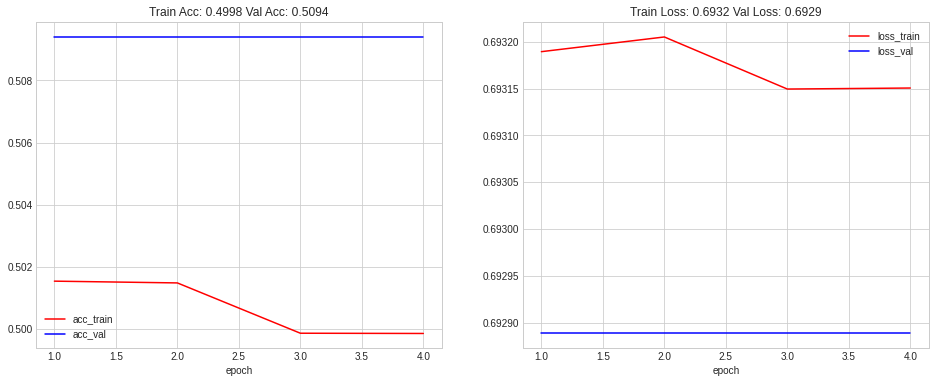

In [72]:
plot_learning_curves(metric_history)

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**:

In [76]:
from sklearn.metrics import f1_score

def evaluate_f1(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            y_true = batch.label
            y_pred = torch.round(torch.sigmoid(predictions))
            acc = f1_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [77]:
test_loss, test_f1 = evaluate_f1(model, test_iter, criterion)
test_f1

0.5967203985592937

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [78]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [80]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.5,
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = out_channels, 
                                kernel_size = (kernel_sizes[0], dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = out_channels, 
                                kernel_size = (kernel_sizes[1], dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = out_channels, 
                                kernel_size = (kernel_sizes[2], dim))
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        embedded = embedded.unsqueeze(1)
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)

In [81]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=64
dropout = 0.5
dim = 300

model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [82]:
model.to(device)

CNN(
  (embedding): Embedding(202303, 300)
  (conv_0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [83]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

In [84]:
max_epochs = 30

Обучите!

In [89]:
import numpy as np

min_loss = np.inf
metric_history = {"train":[], "val":[]} 
cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_acc = 0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_iter)
    train_acc /= len(train_iter)
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc})
    val_loss = 0.0
    train_loss = 0.0
    model.eval()
    
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        val_loss += loss.item()
        val_acc += acc.item()
    
    val_loss /= len(val_iter)
    val_acc /= len(val_iter)
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc})
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.0, Validation Loss: 0.6972229202588399


Epoch: 2, Training Loss: 0.0, Validation Loss: 0.6972229202588399


Epoch: 3, Training Loss: 0.0, Validation Loss: 0.6972229202588399


<All keys matched successfully>

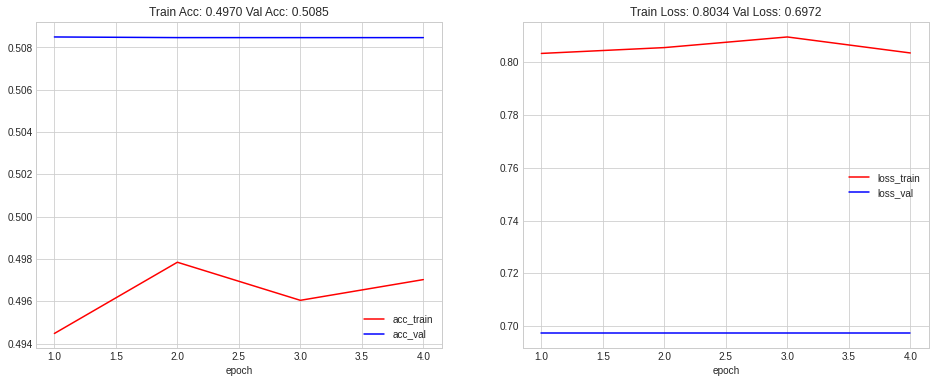

In [90]:
plot_learning_curves(metric_history)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [92]:
def evaluate_f1(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch.label)
            y_true = batch.label
            y_pred = torch.round(torch.sigmoid(predictions))
            acc = f1_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [93]:
test_loss, test_f1 = evaluate_f1(model, test_iter, criterion)
test_f1

0.33879655756907434

## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [94]:
!pip install -q captum

     |████████████████████████████████| 4.4MB 13.1MB/s 


In [97]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [98]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [99]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  neg ( 0.46 ) , delta:  tensor([2.1548e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.40 ) , delta:  tensor([2.8212e-07], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.47 ) , delta:  tensor([2.4104e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.53 ) , delta:  tensor([2.0994e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.47 ) , delta:  tensor([4.5224e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.42 ) , delta:  tensor([4.7239e-05], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [100]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,neg (0.46),pos,-0.22,It was a fantastic performance ! pad
pos,neg (0.40),pos,-1.31,Best film ever pad pad pad pad
pos,neg (0.47),pos,-0.42,Such a great show! pad pad pad
neg,pos (0.53),pos,0.81,It was a horrible movie pad pad
neg,neg (0.47),pos,-0.36,I've never watched something as bad pad
neg,neg (0.42),pos,-1.27,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,neg (0.46),pos,-0.22,It was a fantastic performance ! pad
pos,neg (0.40),pos,-1.31,Best film ever pad pad pad pad
pos,neg (0.47),pos,-0.42,Such a great show! pad pad pad
neg,pos (0.53),pos,0.81,It was a horrible movie pad pad
neg,neg (0.47),pos,-0.36,I've never watched something as bad pad
neg,neg (0.42),pos,-1.27,It is a disgusting movie! pad pad


## Эмбэдинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [102]:
try:
  # tqdm newline issue: https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
  tqdm._instances.clear()
except:
  pass

In [103]:
TEXT.build_vocab(trn, vectors="glove.6B.300d")
# подсказка: один из импортов пока не использовался, быть может он нужен в строке выше :)
LABEL.build_vocab(trn)
word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

.vector_cache/glove.6B.zip: 862MB [06:53, 2.09MB/s]                           
100%|█████████▉| 399853/400000 [00:47<00:00, 8582.59it/s]

In [104]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

100%|█████████▉| 399853/400000 [01:00<00:00, 8582.59it/s]

In [106]:
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model.embedding.weight.shape

model.embedding.weight.data.copy_(word_embeddings)

assert prev_shape == model.embedding.weight.shape
model.to(device)

opt = torch.optim.Adam(model.parameters())

Вы знаете, что делать.

In [108]:
import numpy as np

min_loss = np.inf
metric_history = {"train":[], "val":[]} 
cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_iter)
    train_acc /= len(train_iter)
    metric_history["train"].append({"epoch": epoch,"loss":train_loss, "acc":train_acc})
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        val_loss += loss.item()
        val_acc += acc.item()
    val_loss /= len(val_iter)
    val_acc /= len(val_iter)
    metric_history["val"].append({"epoch": epoch,"loss":val_loss, "acc":val_acc})
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.7030691891691111, Validation Loss: 0.17625259494377396


Epoch: 2, Training Loss: 0.7026565422976974, Validation Loss: 0.17625259494377396


Epoch: 3, Training Loss: 0.7028608544029459, Validation Loss: 0.17625259494377396


<All keys matched successfully>

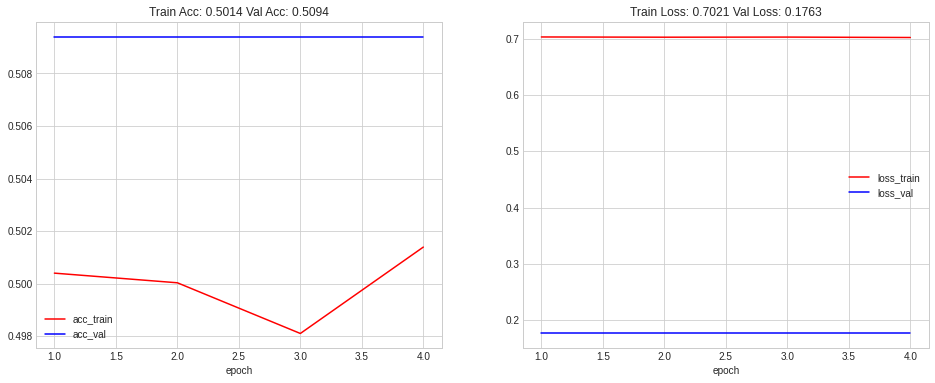

In [109]:
plot_learning_curves(metric_history)

Посчитайте f1-score вашего классификатора.

**Ответ**:

In [110]:
test_loss, test_f1 = evaluate_f1(model, test_iter, loss_func)
test_f1

0.497077019020185

Проверим насколько все хорошо!

In [111]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.51 ) , delta:  tensor([8.4476e-06], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.44 ) , delta:  tensor([9.9831e-06], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.47 ) , delta:  tensor([5.4911e-06], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.48 ) , delta:  tensor([2.4498e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.50 ) , delta:  tensor([1.5257e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.47 ) , delta:  tensor([2.2698e-06], device='cuda:0', dtype=torch.float64)


In [112]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.51),pos,1.39,It was a fantastic performance ! pad
pos,neg (0.44),pos,-0.36,Best film ever pad pad pad pad
pos,neg (0.47),pos,0.69,Such a great show! pad pad pad
neg,neg (0.48),pos,1.22,It was a horrible movie pad pad
neg,pos (0.50),pos,1.55,I've never watched something as bad pad
neg,neg (0.47),pos,0.90,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.51),pos,1.39,It was a fantastic performance ! pad
pos,neg (0.44),pos,-0.36,Best film ever pad pad pad pad
pos,neg (0.47),pos,0.69,Such a great show! pad pad pad
neg,neg (0.48),pos,1.22,It was a horrible movie pad pad
neg,pos (0.50),pos,1.55,I've never watched something as bad pad
neg,neg (0.47),pos,0.90,It is a disgusting movie! pad pad
